# An Unequal-Variance Account of The Positive Evidence Bias 

Subjective confidence ratings in perceptual 2 Alternative Forced Choice (2AFC) tasks have been shown to be disproportionally affected by evidence supporting the perceptual decision compared to contradicting evidence (e.g. Koizumi et al., 2015; Rausch et al., 2017; Samaha et al., 2016, 2019; Zylberberg et al., 2012; Samaha & Denison, 2020). In a typical experiment, participatns are asked to decide whether the general direction of motion in a randomly moving dot array is left or right, and then rate their confidence in their decision. Increasing the total number of dots that are moving to the left and to the right has no effect on accuracy, but enhances overall confidence.

Here I show that some main aspects of PEB are expected when allowing for the signal channel to have more variance than the noise channel.

## Basic Model

In the following model of a 2AFC perceptual task, on each trial the participant observes two quantities: the total motion energy (or the number of points moving) to the right ($E_r$), and the total motion energy to the left ($E_l$). Then, the participant uses the log likelihood ratio ($LLR = log(p(E_r,E_l|right))-log(p(E_r,E_l|left))$ to decide <span style="font-variant:small-caps;">left</span> or <span style="font-variant:small-caps;">right</span>. Confidence can be proportional to $|LLR|$. Motion energy for the true direction is sampled from a Gaussian with mean 1 ($E_t \sim \mathcal{N}(1,1)$), and motion energy for the opposite direction is sampled from a Gaussian with mean 0 ($E_o \sim \mathcal{N}(0,1)$). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import poisson
import statsmodels.formula.api as sm

np.random.seed(1)

class Model:
    def __init__(self, mu, sigma):
        
        self.df = pd.DataFrame()
        self.mu = mu
        self.sigma = sigma
    
    def runModel(self, num_trials):

        # first, decide which is the true direction in each trial (p=0.5)
        self.df['direction'] = ['r' if flip else 'l' for flip in np.random.binomial(1,0.5,num_trials)] 

        self.getMotionEnergy()
        
        self.extractLLR()

        self.makeDecision()

        self.rateConfidence()
        
        self.df['correct'] = self.df.apply(lambda row: row.direction==row.decision, axis=1)
        
        #energy in chosen direction
        self.df['E_c'] = self.df.apply(lambda row: row.E_r if row.decision=='r' else row.E_l, axis=1)
        
        #energy in unchosen direction
        self.df['E_u'] = self.df.apply(lambda row: row.E_l if row.decision=='r' else row.E_r, axis=1)
        
    def getMotionEnergy(self):
    # sample the motion energy for left and right as a function of the true direction
        self.df['E_r'] = self.df.apply(lambda row: np.random.normal(self.mu[1] if row.direction=='r' else self.mu[0],\
                               self.sigma[1]**2 if row.direction=='r' else self.sigma[0]**2), axis=1)

        self.df['E_l'] = self.df.apply(lambda row: np.random.normal(self.mu[1] if row.direction=='l' else self.mu[0],\
                               self.sigma[1]**2 if row.direction=='l' else self.sigma[0]**2), axis=1)
    
    def extractLLR(self):
        
        # extract the Log Likelihood Ratio (LLR) log(p(Er|r))-log(p(Er|l)) + log(p(El|r))-log(p(El|l))
        self.df['LLR'] = self.df.apply(lambda row: \
                            np.log(norm.pdf(row.E_r,self.mu[1],self.sigma[1]**2))- \
                            np.log(norm.pdf(row.E_r,self.mu[0],self.sigma[0]**2)) + \
                            np.log(norm.pdf(row.E_l,self.mu[0],self.sigma[0]**2))- \
                            np.log(norm.pdf(row.E_l,self.mu[1],self.sigma[1]**2)), axis=1)
    def makeDecision(self):
        
        # we assume that our participant just chooses the direction associated with higher likelihood
        self.df['decision'] =  self.df.apply(lambda row: 'r' if row.LLR>0 else 'l', axis=1)
        
    def rateConfidence(self):
        
        # and rates their confidence in proportion to the absolute LLR
        self.df['confidence'] = abs(self.df['LLR'])
    
    def plot(self):
        # plot accuracy
        self.df['correct'].value_counts(normalize=1,sort=0).plot(kind='bar',title='Accuracy')
        plt.ylabel('proportion')
        plt.show()

        # plot confidence as a function of accuracy
        self.df.groupby('correct').mean()['confidence'].plot(kind='bar',title='confidence', 
                                                             yerr=self.df.groupby('correct').sem()['confidence'])
        plt.ylabel('confidence')
        plt.show()
    
    def plotPEB(self):
        ax1 = sns.regplot(x="confidence", y='E_c',data=self.df)
        sns.regplot(x="confidence", y='E_u',data=self.df,ax=ax1,color='red')
        ax1.set(ylabel="motion energy")
        ax1.legend(labels=['chosen', 'unchosen'])
        
        #get coefficients
        self.ols = sm.ols(formula="confidence ~ E_c + E_u", data=self.df).fit()
        self.corr_chosen = self.df.confidence.corr(self.df.E_c)
        self.corr_unchosen = self.df.confidence.corr(self.df.E_u)
        
        print("Correlation of confidence with chosen : % .2f, unchosen : % .2f" %\
          (self.corr_chosen,self.corr_unchosen)) 

model01 = Model(mu=[0,1],sigma=[1,1])
model01.runModel(num_trials = 1000)
model01.plot()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

Accuracy is around 0.75 and confidence for correct responses is higher, as expected. The next thing that we want to do is to plot is the motion energy in the chosen and unchosen directions as a function of decision confidence. We expect a positive correlation of confidence with the chosen direction and a negative correlation with the unchosen direction.

Correlation of confidence with chosen :  0.60, unchosen : -0.57


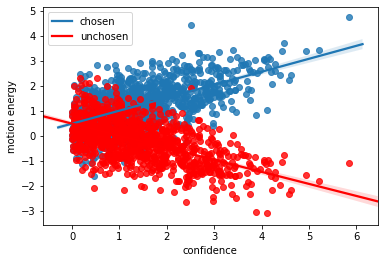

In [2]:
# plot confidence against motion energy in chosen and unchosen directions
model01.plotPEB()

This very simplistic model shows no PEB, as evident from the negative slope for motion energy in the unchosen direction as a function of confidence, and from the fact that the correlation coefficients for $E_c$ and $E_u$ are very similar (but in opposite directions).

## Unequal Variance Model

The next model will be identical to this first model, except that we are going to take one additional fact into account: the variance of signal is typically higher than the variance of noise. So if the dots were moving to the right, $E_r$ should be sampled from a distribution of higher variance compared to $E_l$. In the following simulation I've chosen the arbitrary values of $E_t \sim \mathcal{N}(1,1.2)$ and $E_o \sim \mathcal{N}(0,1)$. 

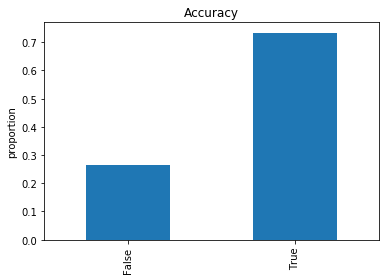

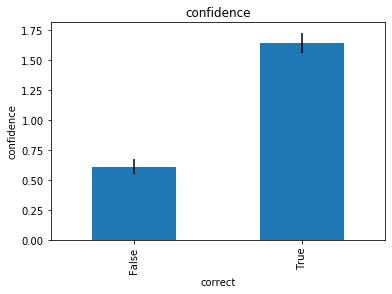

Correlation of confidence with chosen :  0.84, unchosen :  0.07


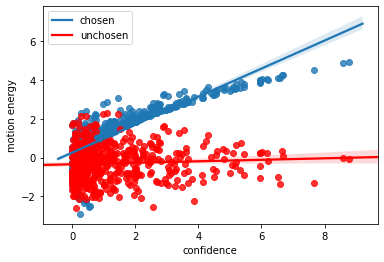

In [3]:
model02 = Model(mu=[0,1],sigma=[1,1.2]); # here sigma is different for the true and opposite directions
model02.runModel(num_trials = 500)
model02.plot()
model02.plotPEB() 

Making the variance of the motion energy in the true direction higher gives rise to PEB. Notice that all we changed was increasing the variance of the true direction or motion from 1 to 1.2! If this is a true PEB and not merely higher correlation with motion energy in the true direction, we should see it not only for correct responses, but also for incorrect responses (Kiani et al., 2014; Rausch & Zehetleitner, 2016):

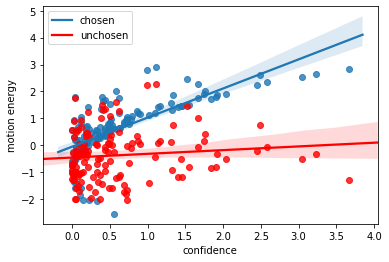

Correlation of confidence with chosen :  0.84, unchosen :  0.07


In [4]:
errors = model02.df[model02.df.correct==0]
ax1 = sns.regplot(x="confidence", y='E_c',data=errors)
sns.regplot(x="confidence", y='E_u',data=errors,ax=ax1,color='red')
ax1.set(ylabel="motion energy")
ax1.legend(labels=['chosen', 'unchosen'])
plt.show()

print("Correlation of confidence with chosen : % .2f, unchosen : % .2f" %\
      (model02.corr_chosen,model02.corr_unchosen)) 

And indeed, this is what we find. To reiterate, a change to the variance of the motion energy in the true direction of motion (from 1 to 1.2) gave rise to an effect that can look metacognitive or higher-order, although in this simulation it is not. There are two main reasons for assuming higher variance in the true direction of motion (or true orientation of a visual grating). First, often this is how the experiment is designed in the first place. For example, in Zylberberg et al (2012) a small set of coherently moving dots was embedded in an array of randomly moving dots. Importantly, the number of coherently moving dots was itself randomly determined, sampled from a Gaussian distribution once in every four frames. This means that there were two sources of variability for the true direction of motion (variability in the randomly moving dots and variability in the number of coherently moving dots), but only one source of variability for the opposite direction. Secondly, the representation of signal is empirically more noisy than the representaion of noise, as evident from the better fit of unequal-variance SDT models to visual detection behavioural data.

Let's examine one more biologically-inspired variant of this model, using Poisson instead of normal distributions to represent the incoming perceptual evidence supporting right or left motion. This resembles neuronal firing rate, or the number of neurons from an orientation-selective population that exceeded a certain firing-rate threshold in response to a stimulus. A Poisson distribution has only one rate parameter, which is affecting both its mean and its variance.

## Poisson Model

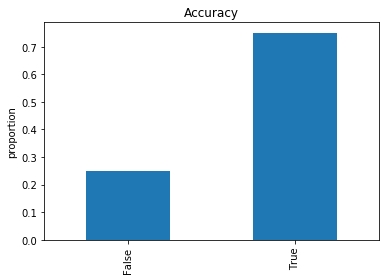

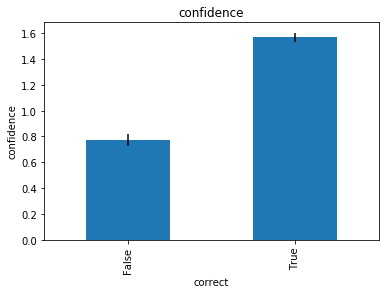

Correlation of confidence with chosen :  0.72, unchosen : -0.36


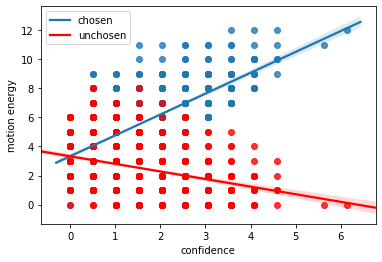

In [5]:
#inherit class Model and make a few changes
class PoissonModel(Model):
    
    # poisson distribution has only one parameter
    def __init__(self, lmbda):
        
        self.df = pd.DataFrame()
        self.lmbda = lmbda
        
    def getMotionEnergy(self):
    # sample the motion energy for left and right as a function of the true direction
        self.df['E_r'] = self.df.apply(lambda row: np.random.poisson(self.lmbda[1] if row.direction=='r' else self.lmbda[0]), \
                                       axis=1)

        self.df['E_l'] = self.df.apply(lambda row: np.random.poisson(self.lmbda[1] if row.direction=='l' else self.lmbda[0]), \
                                       axis=1)
    
    def extractLLR(self):
        
        # extract the Log Likelihood Ratio (LLR) log(p(Er|r))-log(p(Er|l)) + log(p(El|r))-log(p(El|l))
        self.df['LLR'] = self.df.apply(lambda row: \
                            np.log(poisson.pmf(row.E_r,self.lmbda[1]))- \
                            np.log(poisson.pmf(row.E_r,self.lmbda[0])) + \
                            np.log(poisson.pmf(row.E_l,self.lmbda[0]))- \
                            np.log(poisson.pmf(row.E_l,self.lmbda[1])), axis=1)

model03 = PoissonModel(lmbda=[3,5])
model03.runModel(num_trials = 1000)
model03.plot()   
model03.plotPEB() 

Again, the model is predicting a positive evidence bias, and the effect persists in error trials too:

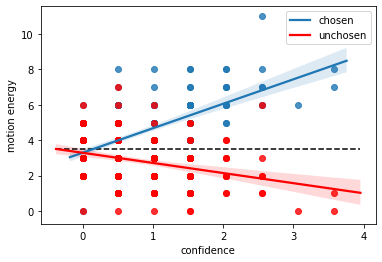

In [6]:
errors = model03.df[model03.df.correct==0]
ax1 = sns.regplot(x="confidence", y='E_c',data=errors)
sns.regplot(x="confidence", y='E_u',data=errors,ax=ax1,color='red')
ax1.set(ylabel="motion energy")
ax1.legend(labels=['chosen', 'unchosen'])
ax1.hlines(3.5,ax1.get_xlim()[0],ax1.get_xlim()[1], linestyles='dashed')
plt.show()


## The High/Low PE Design

The simulations above are a good model for Zylberberg (2012), where reverse correlation allowed to isolate the effects of positive and negative evidence on decision and confidence. A more common design is one where overall stimulus contrast is manipulated between trials, and participants show higher confidence for stimuli presented with higher contrast, even when contrast has no effect on performance, and even for incorrect responses (Samaha 2016, 2019; Rausch, 2017). This seeminly paradoxical positive effect of stimulus visibility on confidence in incorrect responses has led to the proposal that confidence is based on both evidence and overall visibility (Rausch, 2017). 

The following simulation is based on the Poisson model, except that there are two conditions: high and low contrast. Contrast is affecting both positive and negative energy in the same way, by multiplying the Poisson $\lambda$ parameter by a constant. At a given trial, the participant is not told whether they are seeing a high contrast or a low contrast, so they have to marginalize over both world state in their inference. 

This model predicts higher confidence for the high contrast condition, even in error trials, and even for model parameters where performance is equal or higher for low contrast (e.g. 'low':[4,5],'high':[12,14])!

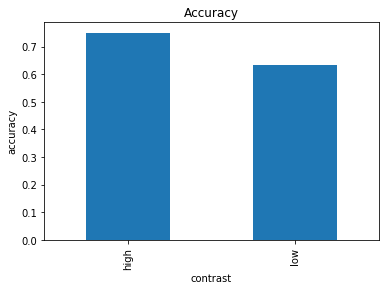

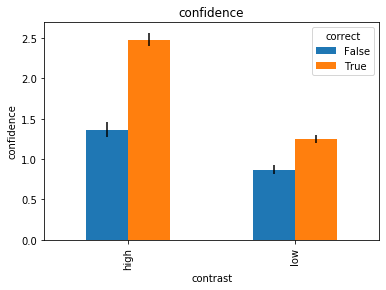

Correlation of confidence with chosen :  0.64, unchosen :  0.15


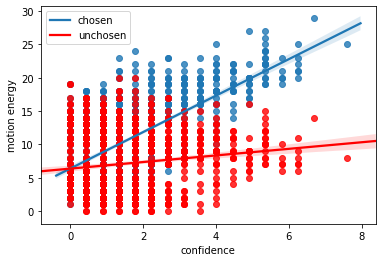

In [64]:
class SamahaModel(PoissonModel):

    def runModel(self, num_trials):

        # first, decide which is the true direction in each trial (p=0.5)
        self.df['direction'] = ['r' if flip else 'l' for flip in np.random.binomial(1,0.5,num_trials)] 
        
        # first, decide which trials are high contrast (p=0.5)
        self.df['contrast'] = ['high' if flip else 'low' for flip in np.random.binomial(1,0.5,num_trials)] 

        self.getMotionEnergy()
        
        self.extractLLR()

        self.makeDecision()

        self.rateConfidence()
        
        self.df['correct'] = self.df.apply(lambda row: row.direction==row.decision, axis=1)
        
        #energy in chosen direction
        self.df['E_c'] = self.df.apply(lambda row: row.E_r if row.decision=='r' else row.E_l, axis=1)
        
        #energy in unchosen direction
        self.df['E_u'] = self.df.apply(lambda row: row.E_l if row.decision=='r' else row.E_r, axis=1)
        
    def getMotionEnergy(self):
    # sample the motion energy for left and right as a function of the true direction
        self.df['E_r'] = self.df.apply(lambda row: np.random.poisson(self.lmbda[row.contrast][1] if row.direction=='r' \
                                                                     else self.lmbda[row.contrast][0]), axis=1)

        self.df['E_l'] = self.df.apply(lambda row: np.random.poisson(self.lmbda[row.contrast][1] if row.direction=='l' \
                                                                     else self.lmbda[row.contrast][0]),  axis=1)
    
    def extractLLR(self):
        
        # extract the Log Likelihood Ratio (LLR) log(p(Er|r))-log(p(Er|l)) + log(p(El|r))-log(p(El|l)),
        # while marginalizing over high and low contrast
         self.df['LLR'] = self.df.apply(lambda row: \
                            np.log(poisson.pmf(row.E_r,self.lmbda['high'][1]))- \
                            np.log(poisson.pmf(row.E_r,self.lmbda['high'][0])) + \
                            np.log(poisson.pmf(row.E_l,self.lmbda['high'][0]))- \
                            np.log(poisson.pmf(row.E_l,self.lmbda['high'][1])) +
                            np.log(poisson.pmf(row.E_r,self.lmbda['low'][1]))- \
                            np.log(poisson.pmf(row.E_r,self.lmbda['low'][0])) + \
                            np.log(poisson.pmf(row.E_l,self.lmbda['low'][0]))- \
                            np.log(poisson.pmf(row.E_l,self.lmbda['low'][1])) , axis=1)
    
    def plot(self):
        # plot accuracy
        self.df.groupby('contrast')['correct'].mean().plot(kind='bar',title='Accuracy')
        plt.ylabel('accuracy')
        plt.show()

        # plot confidence as a function of accuracy
        self.df.groupby(['contrast','correct']).mean()['confidence'].unstack('correct').plot(kind='bar',title='confidence', 
                     yerr=self.df.groupby(['contrast','correct']).sem()['confidence'].unstack('correct'))
        plt.ylabel('confidence')
        plt.show()

model04 = SamahaModel(lmbda = {'low':[4,5],'high':[12,15]})
model04.runModel(num_trials = 1000)
model04.plot()
model04.plotPEB()

## Detection

Lastly, I applied the unequal-variance model to a detection setting, where participants report whether they detected any coherent motion at all.

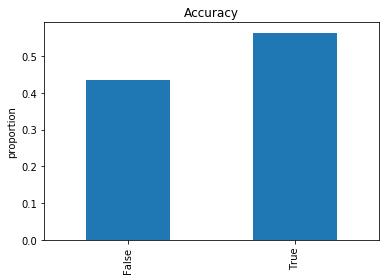

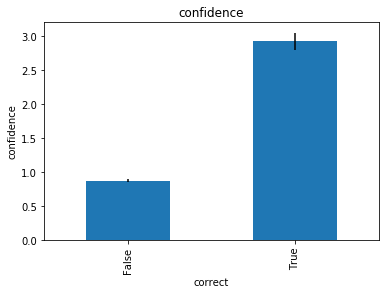

Correlation of confidence with chosen :  0.66, unchosen : -0.03


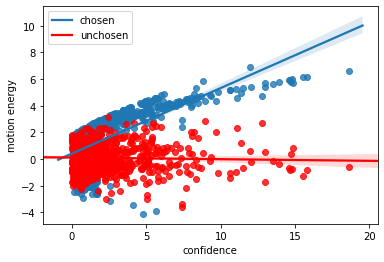

In [72]:
def pseudoDisLabels(direction, response):
    if direction == 'r':
        if response == 'p':
            return 'r'
        else:
            return 'l'
    else:
        if response == 'p':
            return 'l'
        else:
            return 'p'

class DetectionModel(Model):
    
    def runModel(self, num_trials):

        # first, decide which is the true direction in each trial (p=0.5)
        self.df['direction'] = ['r' if flip else 'l' for flip in np.random.binomial(1,0.5,num_trials)] 
        
        # decide whether motion is present or absent. ONLY PRESENT TRIALS
        self.df['motion'] = ['p' if flip else 'a' for flip in np.random.binomial(1,1,num_trials)] 
        
        self.getMotionEnergy()
        
        self.extractLLR()

        self.makeDecision()

        self.rateConfidence()
        
        self.df['correct'] = self.df.apply(lambda row: row.motion==row.decision, axis=1)
        
        #energy in chosen direction
        self.df['E_c'] = self.df.apply(lambda row: row.E_r if pseudoDisLabels(row.direction, row.decision)=='r' else row.E_l, axis=1)
        
        #energy in unchosen direction
        self.df['E_u'] = self.df.apply(lambda row: row.E_l if pseudoDisLabels(row.direction, row.decision)=='r' else row.E_r, axis=1)
        
    def getMotionEnergy(self):
    # sample the motion energy for left and right as a function of the true direction
        self.df['E_r'] = self.df.apply(lambda row: np.random.normal(self.mu[1] if row.direction=='r' and row.motion=='p' else self.mu[0],\
                               self.sigma[1]**2 if row.direction=='r' and row.motion =='p' else self.sigma[0]**2), axis=1)

        self.df['E_l'] = self.df.apply(lambda row: np.random.normal(self.mu[1] if row.direction=='l' and row.motion == 'p' else self.mu[0],\
                               self.sigma[1]**2 if row.direction=='l' and row.motion == 'p' else self.sigma[0]**2), axis=1)
    
    def extractLLR(self):
        
        # extract the Log Likelihood Ratio (LLR) log(p(Er|present))-log(p(Er|absent))
        # + log(p(El|present))-log(p(El|absent))
        self.df['LLR'] = self.df.apply(lambda row: \
                            np.log(0.5*norm.pdf(row.E_r,self.mu[1],self.sigma[1]**2) * \
                            norm.pdf(row.E_l,self.mu[0],self.sigma[0]**2) + \
                            0.5*norm.pdf(row.E_l,self.mu[1],self.sigma[1]**2) *  \
                            norm.pdf(row.E_l,self.mu[1],self.sigma[1]**2))- \
                            np.log(norm.pdf(row.E_r,self.mu[0],self.sigma[0]**2)) - \
                            np.log(norm.pdf(row.E_l, self.mu[0],self.sigma[0])), axis=1)
    def makeDecision(self):
        
        # we assume that our participant just chooses the direction associated with higher likelihood
        self.df['decision'] =  self.df.apply(lambda row: 'p' if row.LLR>0 else 'a', axis=1)
        
    def rateConfidence(self):
        
        # and rates their confidence in proportion to the absolute LLR
        self.df['confidence'] = abs(self.df['LLR'])
        
model05 = DetectionModel(mu=[0,1.5],sigma=[1,1.3])
model05.runModel(num_trials = 1000)
model05.plot()
model05.plotPEB()

## Conclusion

To conclude, I will list main findings from the PEB literature and compare them against this model's predictions:

1. Zylberberg et al., 2012: In a motion-disctimination task, motion energy in the chosen direction is more correlated with confidence compared to motion energy in the unchosen direction. This finding is successfully accounted for by the unequal-variance model.
1. Samaha et al., 2016, 2019; Koizumi 2015: In an orientation discrimination task, increasing overall stimulus contrast (of both signal and noise) boosts confidence, while having no effect on accuracy. This finding can be accommodated by the current model, if the participant does not know which trials are high-contrast and which trials are low-contrast, and inference is based on the expectation of evidence-strength marginalized on both conditions.
1. Rausch et al., 2017: In a backward-masking orientation discrimination task, SOA is positively correlated with confidence, even in uncorrect responses. This finding is successfully accounted for by this model similarly to the previous point.
1. Samaha & Denison, 2020: PEB persists when confidence ratings are given simultanously with the decision even when the stimulus persists until response, suggesting that the effect is not post-decisional. This finding is in line iwth the predictions made by the unequal-variance model in which both decision and confidence are extracted by the same quantity (LLR).
